# Results Analysis

In [1]:
from optimization.acs import ACS_VRP,ACS_TSP
from optimization.bso import BSO_VRP,BSO_TSP
from optimization.hybrid_acs_bso import ACSBSO_VRP,ACSBSO_TSP

from optimization.aco import ACO_VRP,ACO_TSP
from optimization.haco import HACO_VRP,HACO_TSP

from optimization.koneksi import ConDB

import sql_connection
import json
import time
import random
import datetime
import copy

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [2]:
def generate_data(n = 30, random_state = None):
    random.seed(random_state)
    query = """SELECT 
                    p.post_id,
                    p.post_type,
                    CASE
                        WHEN pj.pj_jam_buka = pj.pj_jam_tutup THEN "tutup"
                        ELSE "buka"
                    END AS is_operate
                FROM 
                    posts p
                LEFT JOIN
                    posts_jadwal pj
                    ON p.post_id = pj.pj_id_tempat AND pj.pj_hari = "minggu"
                """

    df_location = sql_connection.read_from_sql(query)
    
    tourid = df_location[(df_location['post_type']=="location")&
                         (df_location['is_operate'] != "tutup")]['post_id'].values.tolist()
    tourid = random.sample(tourid,n)
    idhotel = df_location[df_location['post_type']=="hotel"]['post_id'].values.tolist()
    idhotel = idhotel[random.randint(0,len(idhotel)-1)]
    
    db = ConDB()

    hotel = db.HotelbyID(idhotel)
    tur = db.WisatabyID(tourid)
    timematrix = db.TimeMatrixbyID(hotel._id,tourid)
    
    return hotel,tur,timematrix

## Analisis
scenario analisis:
1. semua degree 1, 30 pois, 3 hari wisata, all method cek fitness, travel duration, total tarif, rata-rata rating, poi included, running time
2. semua degree 1, 0, 5-10-15-20-25-30 pois, 3 hari wisata, all method, cek running time
3. degree travel duration 1 sisanya 0, 5-10-15-20-25-30 pois, 365 hari wisata, all method, cek travel duration and travel days
4. degree tarif 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek total tarif
5. degree rating 1 sisanya 0, 30 pois, 3 hari wisata, all method, cek rata rata rating

story:
1. overview: jelasin dulu secara keseluruhan dengan scenario analisis no. 1 terus breakdown best model dengan beberapa random berbeda dan running time nya

In [3]:
def find_node(node_id,tour):
    for node in tour:
        if node._id == node_id:
            return node
    return False

def time_to_second(time):
    return (time.hour*3600)+(time.minute*60)+time.second

def diff_second_between_time(time_a,time_b):
    #input: time_a and time_b, datetime.time()
    #output: time_b - time_a, seconds (int)
    return time_to_second(time_b) - time_to_second(time_a)

def get_attribute_analysis(solution):
    days_needed = len(solution)
    poi_included = len(sum([sol["index"] for sol in solution],[]))
    avg_rating = sum(sum([sol["rating"] for sol in solution],[]))/poi_included
    total_tarif = sum(sum([sol["tarif"] for sol in solution],[]))
    total_duration = sum([diff_second_between_time(j[0],j[-1]) for j in [i['waktu'] for i in solution]])
    return days_needed,poi_included,avg_rating,total_tarif,total_duration

def get_analysis(model,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating):
    start = time.time()
    model.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness = model.construct_solution()[-2:]
    end = time.time()
    run_time = end-start
    days_needed,poi_included,avg_rating,total_tarif,total_duration = get_attribute_analysis(solution)
    results = {"solution":[sol["index"] for sol in solution],
              "fitness":fitness,
              "days_needed":days_needed,
              "poi_included":poi_included,
              "avg_rating":avg_rating,
              "total_tarif":total_tarif,
              "total_duration":total_duration,
              "run_time":run_time}
    
    return results

In [4]:
def get_detail_node_on_solution(solution):
    db = ConDB()
    node_solution = []
    for i in solution:
        nodes = db.WisatabyID(i)
        node_solution.append(nodes)
    return node_solution

def visualize_solution(solution_node,hotel):
    # Sample VRP data
    vrp_data = [[hotel]+sol+[hotel] for sol in solution_node]
    
    # Generate random node coordinates
    node_coords = {node._id: (float(node.long), float(node.lat)) for node in set(node for route in vrp_data for node in route)}  

    # Number of routes (you can calculate this)
    num_routes = len(vrp_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,9))

    # Define the colors for routes using a colormap
    cmap = plt.get_cmap('tab20', num_routes)

    for i, route in enumerate(vrp_data):
        x = [node_coords[node._id][0] for node in route]
        y = [node_coords[node._id][1] for node in route]
        color = cmap(i)  # Get the color for the route
        # Plot the nodes (scatter plot)
        ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)

        for j in range(len(x) - 1):
            # Make the arrow heads larger by increasing mutation_scale
            arrow = FancyArrowPatch(
                (x[j], y[j]), (x[j + 1], y[j + 1]),
                arrowstyle='->', mutation_scale=15, color=color
            )
            ax.add_patch(arrow)

    # Set node 159 (start and end point) to black
    start_x, start_y = node_coords[hotel._id]
    ax.scatter(start_x, start_y, c='k', label='Hotel', s=100)

    # Add labels for nodes
    for node, (x, y) in node_coords.items():
        ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add legend
    ax.legend()

    plt.show()



### 1. Overview

In [33]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30) #random state 50 blacklist
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


In [34]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[76, 95, 93, 71, 18, 35, 73, 88],
  [11, 54, 34, 1, 9, 7, 22, 40],
  [16, 69, 4, 86, 74, 10, 46]],
 'fitness': 0.6886417340998086,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 123960,
 'run_time': 13.057544708251953}

In [36]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[1, 53, 7, 10, 9, 4, 74],
  [69, 11, 76, 40, 39, 64, 51],
  [34, 29, 47, 16, 95, 73]],
 'fitness': 0.5573323868958789,
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.59,
 'total_tarif': 201500,
 'total_duration': 126060,
 'run_time': 14.970253944396973}

In [37]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.5691533260977705,
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.9690842628479004}

In [38]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 4, 86, 18, 95, 73, 16, 71],
  [47, 54, 29, 34, 1],
  [76, 22, 72, 9, 7, 10, 11, 35, 88]],
 'fitness': 0.5631434042148328,
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.518181818181818,
 'total_tarif': 228000,
 'total_duration': 118260,
 'run_time': 28.259628534317017}

In [35]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[34, 74, 40, 93, 73],
  [16, 54, 71, 95, 86, 88, 35, 10, 9],
  [69, 11, 4, 18, 22, 76, 1, 7, 46]],
 'fitness': 0.692216836980467,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120300,
 'run_time': 94.49507784843445}

In [39]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[35, 88, 4, 11, 10, 9, 7, 46],
  [69, 86, 18, 1, 53, 95, 22, 73],
  [72, 47, 16, 54, 71, 93]],
 'fitness': 0.5629285764206399,
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.577272727272727,
 'total_tarif': 225500,
 'total_duration': 128520,
 'run_time': 110.97899723052979}

In [40]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[76, 18, 16, 46, 88, 73, 40, 35, 4],
  [34, 51, 95, 71, 22, 9],
  [11, 54, 93, 10, 74, 7, 1]],
 'fitness': 0.6741053846212576,
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.559090909090909,
 'total_tarif': 25000,
 'total_duration': 128820,
 'run_time': 8.810433626174927}

In [41]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[53, 4, 9, 7, 46, 73],
  [18, 39, 76, 11, 16, 22],
  [69, 51, 64, 34, 40, 35]],
 'fitness': 0.6093853970838098,
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.616666666666666,
 'total_tarif': 81500,
 'total_duration': 123480,
 'run_time': 10.065051317214966}

In [42]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[16, 11, 69, 34, 51, 7, 46],
  [76, 95, 71, 93, 9, 40, 73, 88],
  [1, 22, 86, 18, 35, 4, 10, 74]],
 'fitness': 0.6864573669180293,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.591304347826086,
 'total_tarif': 33000,
 'total_duration': 127260,
 'run_time': 15.274240493774414}

In [43]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[53, 46, 73, 10, 9, 7],
  [16, 47, 72, 86, 18, 74, 40],
  [69, 76, 39, 64, 34, 51]],
 'fitness': 0.5262807889687587,
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.6157894736842096,
 'total_tarif': 246500,
 'total_duration': 123960,
 'run_time': 21.9304940700531}

### 2. Overview: Variasi hasil berdasarkan node yang berbeda

In [44]:
random_ls = [10,30,60,80,100]
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("Hybrid ACS-BSO - VRP - ",i+1)
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    print("fitness = ",results_acsbso_vrp["fitness"])
    print("==========================")

C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


Hybrid ACS-BSO - VRP -  1
fitness =  0.6494000145671729


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


Hybrid ACS-BSO - VRP -  2
fitness =  0.692216836980467
Hybrid ACS-BSO - VRP -  3


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


fitness =  0.6783556799851964


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


Hybrid ACS-BSO - VRP -  4
fitness =  0.6902856916745805


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


Hybrid ACS-BSO - VRP -  5
fitness =  0.6471292255360653


In [45]:
random_ls = [10,30,60,80,100]
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("HACO - VRP - ",i+1)
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    print("fitness = ",results_haco_vrp["fitness"])
    print("==========================")

HACO - VRP -  1


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


fitness =  0.6435807021377327


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


HACO - VRP -  2
fitness =  0.6864573669180293
HACO - VRP -  3


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


fitness =  0.6738289310140028
HACO - VRP -  4


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


fitness =  0.6848110528464795


C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


HACO - VRP -  5
fitness =  0.6411878675113739


### 3. Overview: Visualization

In [46]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30) #random state 50 blacklist
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

C:\Users\rahma\Documents\kuliah\thesis\rahmat_code\travel-itinerary-recommendation\sql_connection.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, mydb)


In [47]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[34, 74, 40, 93, 73],
  [16, 54, 71, 95, 86, 88, 35, 10, 9],
  [69, 11, 4, 18, 22, 76, 1, 7, 46]],
 'fitness': 0.692216836980467,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 120300,
 'run_time': 87.3820252418518}

C:\Users\rahma\AppData\Local\Temp\ipykernel_9316\2708662994.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)


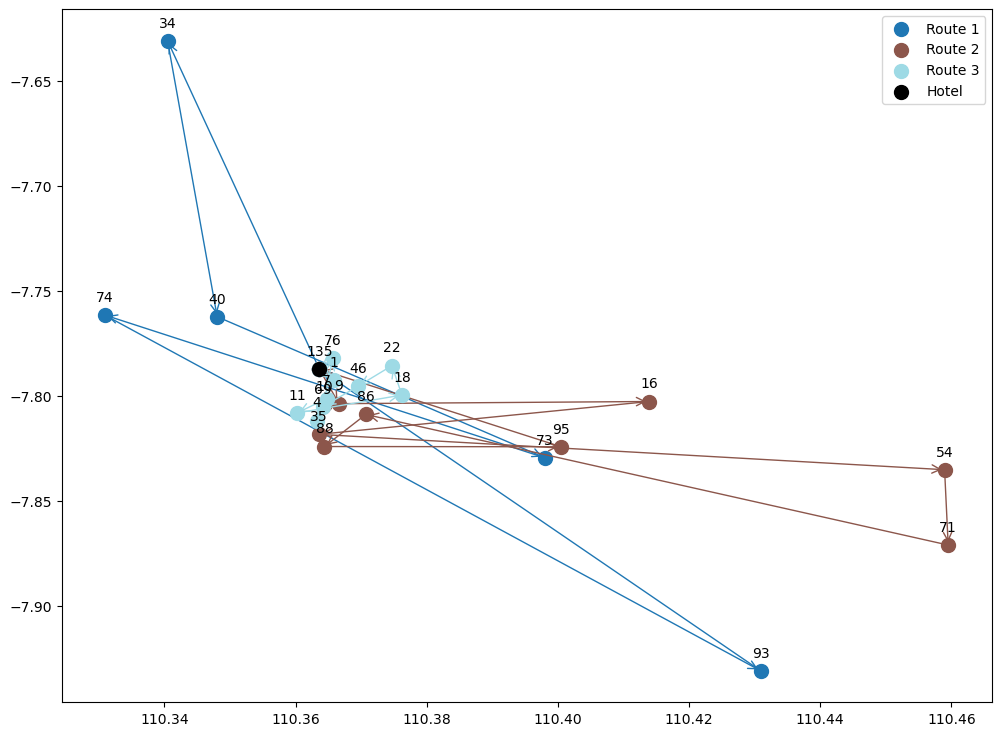

In [48]:
sol_node = get_detail_node_on_solution(results_acsbso_vrp['solution'])
visualize_solution(sol_node,hotel)

In [49]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[16, 11, 69, 34, 51, 7, 46],
  [76, 95, 71, 93, 9, 40, 73, 88],
  [1, 22, 86, 18, 35, 4, 10, 74]],
 'fitness': 0.6864573669180293,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.591304347826086,
 'total_tarif': 33000,
 'total_duration': 127260,
 'run_time': 14.938490629196167}

C:\Users\rahma\AppData\Local\Temp\ipykernel_9316\2708662994.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)


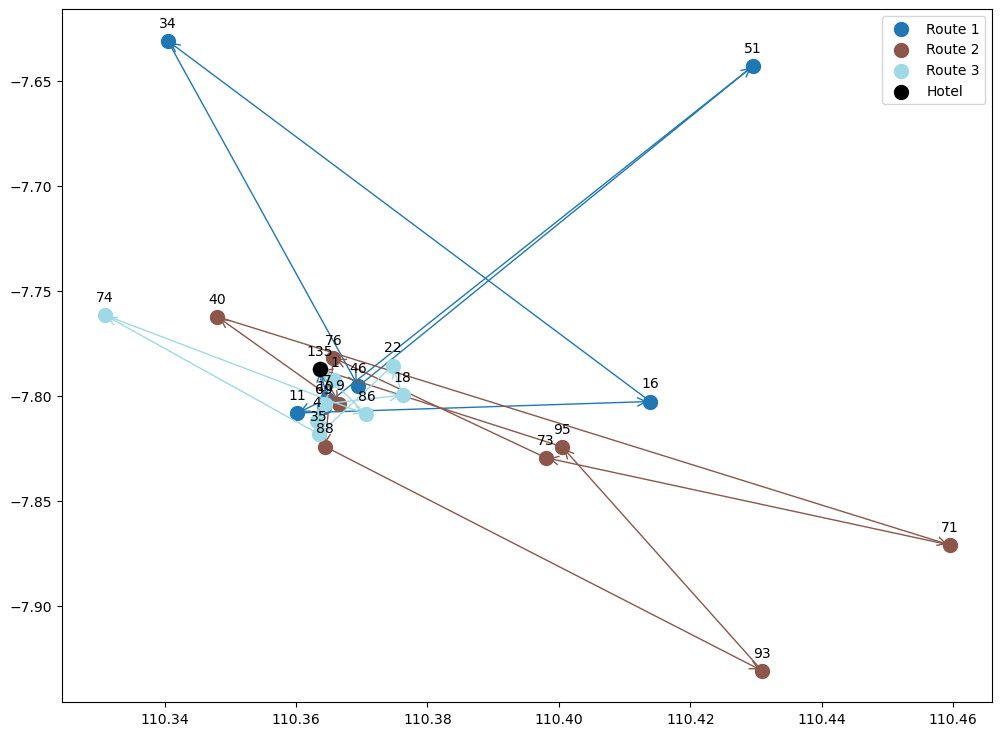

In [50]:
sol_node = get_detail_node_on_solution(results_haco_vrp['solution'])
visualize_solution(sol_node,hotel)

### 4. Running Time

In [7]:
n = [5,10,15,20,25,30]
run_time_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acs_vrp"].append(results_acs_vrp["run_time"])
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acs_tsp"].append(results_acs_tsp["run_time"])
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["bso_vrp"].append(results_bso_vrp["run_time"])
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["bso_tsp"].append(results_bso_tsp["run_time"])
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acsbso_vrp"].append(results_acsbso_vrp["run_time"])
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["acsbso_tsp"].append(results_acsbso_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [8]:
run_time_analysis

{'acs_vrp': [0.31362462043762207,
  1.6317250728607178,
  4.346598863601685,
  3.062130928039551,
  8.975558042526245,
  12.780457496643066],
 'acs_tsp': [0.23544692993164062,
  0.9129869937896729,
  2.163102865219116,
  5.806864500045776,
  10.339011192321777,
  15.963364601135254],
 'bso_vrp': [0.06251335144042969,
  0.41005492210388184,
  0.5191915035247803,
  0.9455263614654541,
  0.6454594135284424,
  0.9437882900238037],
 'bso_tsp': [0.11533665657043457,
  0.8411765098571777,
  3.057725429534912,
  7.4024269580841064,
  15.201591968536377,
  27.80937433242798],
 'acsbso_vrp': [2.1948959827423096,
  6.973323345184326,
  12.142411708831787,
  14.93755292892456,
  57.63169074058533,
  86.84850144386292],
 'acsbso_tsp': [0.7797305583953857,
  5.510660171508789,
  20.838329553604126,
  22.969918966293335,
  113.08940434455872,
  110.69467496871948]}

In [11]:
n = [5,10,15,20,25,30]
run_time_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["aco_vrp"].append(results_aco_vrp["run_time"])
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["aco_tsp"].append(results_aco_tsp["run_time"])
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["haco_vrp"].append(results_haco_vrp["run_time"])
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    run_time_analysis["haco_tsp"].append(results_haco_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [12]:
run_time_analysis

{'aco_vrp': [0.5078334808349609,
  1.3141131401062012,
  2.9715335369110107,
  7.019808769226074,
  5.107304334640503,
  9.287899732589722],
 'aco_tsp': [0.37125277519226074,
  1.2223997116088867,
  1.7118768692016602,
  2.683976173400879,
  7.406680583953857,
  12.003194332122803],
 'haco_vrp': [1.1476223468780518,
  4.804590702056885,
  8.572667360305786,
  11.629117250442505,
  9.326182126998901,
  15.174498319625854],
 'haco_tsp': [1.3644392490386963,
  3.5026330947875977,
  8.588392496109009,
  12.400683403015137,
  17.594865083694458,
  22.384727239608765]}

### 5. Travel Duration

In [5]:
n = [5,10,15,20,25,30]
travel_duration_analysis = {
    "acs_vrp": [],
    "acs_tsp": [],
    "bso_vrp": [],
    "bso_tsp": [],
    "acsbso_vrp": [],
    "acsbso_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 100
    dwaktu,dtarif,drating = 1,0,0
    keys = ["total_duration","days_needed"]
    
    print("n = ",i)
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_vrp"].append({key: results_acs_vrp[key] for key in keys})
    
    acs_tsp = ACS_TSP(random_state=100)
    results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acs_tsp"].append({key: results_acs_tsp[key] for key in keys})
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_vrp"].append({key: results_bso_vrp[key] for key in keys})
    
    bso_tsp = BSO_TSP(random_state=100)
    results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["bso_tsp"].append({key: results_bso_tsp[key] for key in keys})
    
    acsbso_vrp = ACSBSO_VRP(random_state=100)
    results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_vrp"].append({key: results_acsbso_vrp[key] for key in keys})
    
    acsbso_tsp = ACSBSO_TSP(random_state=100)
    results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["acsbso_tsp"].append({key: results_acsbso_tsp[key] for key in keys})

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [6]:
travel_duration_analysis

{'acs_vrp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 62820, 'days_needed': 2},
  {'total_duration': 90780, 'days_needed': 3},
  {'total_duration': 120960, 'days_needed': 3},
  {'total_duration': 150720, 'days_needed': 4},
  {'total_duration': 177540, 'days_needed': 4}],
 'acs_tsp': [{'total_duration': 24540, 'days_needed': 1},
  {'total_duration': 84480, 'days_needed': 3},
  {'total_duration': 95280, 'days_needed': 3},
  {'total_duration': 138540, 'days_needed': 4},
  {'total_duration': 156660, 'days_needed': 4},
  {'total_duration': 182880, 'days_needed': 5}],
 'bso_vrp': [{'total_duration': 24960, 'days_needed': 1},
  {'total_duration': 64800, 'days_needed': 2},
  {'total_duration': 94200, 'days_needed': 3},
  {'total_duration': 129480, 'days_needed': 4},
  {'total_duration': 192060, 'days_needed': 5},
  {'total_duration': 182160, 'days_needed': 6}],
 'bso_tsp': [{'total_duration': 25800, 'days_needed': 1},
  {'total_duration': 74820, 'days_needed': 2},
  {'

In [9]:
n = [5,10,15,20,25,30]
travel_duration_analysis = {
    "aco_vrp": [],
    "aco_tsp": [],
    "haco_vrp": [],
    "haco_tsp": []
}
for i in n:
    # setting
    hotel,tur,timematrix = generate_data(n=i,random_state=30)
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("n = ",i)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_vrp"].append(results_aco_vrp["run_time"])
    
    aco_tsp = ACO_TSP(random_state=100)
    results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["aco_tsp"].append(results_aco_tsp["run_time"])
    
    haco_vrp = HACO_VRP(random_state=100)
    results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_vrp"].append(results_haco_vrp["run_time"])
    
    haco_tsp = HACO_TSP(random_state=100)
    results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    travel_duration_analysis["haco_tsp"].append(results_haco_tsp["run_time"])

n =  5
n =  10
n =  15
n =  20
n =  25
n =  30


In [10]:
travel_duration_analysis

{'aco_vrp': [0.5042905807495117,
  1.607271671295166,
  3.0123519897460938,
  7.434915542602539,
  5.364135503768921,
  9.609212160110474],
 'aco_tsp': [0.36096620559692383,
  1.1463730335235596,
  1.7028884887695312,
  2.470151662826538,
  7.923985958099365,
  11.322162866592407],
 'haco_vrp': [1.1588704586029053,
  4.322824716567993,
  8.605764389038086,
  11.456895351409912,
  9.90217137336731,
  15.657648801803589],
 'haco_tsp': [1.3781633377075195,
  3.3770411014556885,
  8.768243312835693,
  12.580437421798706,
  17.26732110977173,
  23.34467101097107]}

### 6. Tarif

In [11]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,1,0

In [12]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[10, 73, 93, 18, 16, 95, 86, 1],
  [74, 40, 7, 11, 46, 53, 4, 88, 9],
  [76, 54, 22, 51, 34, 35]],
 'fitness': 0.8434862370874275,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.573913043478259,
 'total_tarif': 45000,
 'total_duration': 127260,
 'run_time': 3.687053680419922}

In [13]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[40, 71, 39, 51],
  [54, 4, 93, 22, 10],
  [11, 69, 18, 53, 76, 1, 74, 88]],
 'fitness': 0.7307020030234316,
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.552941176470588,
 'total_tarif': 54000,
 'total_duration': 119460,
 'run_time': 3.033057928085327}

In [14]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.6867339065255732,
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.988724946975708}

In [15]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 22, 71, 18, 4, 73],
  [29, 16, 47, 86, 1, 88, 7],
  [76, 54, 34, 95, 64]],
 'fitness': 0.6503913139329807,
 'days_needed': 3,
 'poi_included': 18,
 'avg_rating': 4.51111111111111,
 'total_tarif': 168000,
 'total_duration': 119100,
 'run_time': 26.960572957992554}

In [16]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[54, 4, 76, 22, 93, 73, 10],
  [11, 16, 69, 88, 86, 1, 46, 35, 7, 9],
  [18, 34, 95, 74, 40, 71]],
 'fitness': 0.8616496598639456,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 25500,
 'total_duration': 133140,
 'run_time': 52.68372130393982}

In [17]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[39, 35, 18, 40, 64, 9, 88],
  [69, 86, 54, 95, 51, 1],
  [53, 72, 22, 46]],
 'fitness': 0.64458380574452,
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.5588235294117645,
 'total_tarif': 156500,
 'total_duration': 120780,
 'run_time': 73.67426538467407}

In [18]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[16, 34, 71, 46, 74],
  [40, 11, 76, 88, 10, 9, 73, 4, 51],
  [54, 35, 18, 22, 95, 1, 7]],
 'fitness': 0.8271636432350717,
 'days_needed': 3,
 'poi_included': 21,
 'avg_rating': 4.557142857142857,
 'total_tarif': 22500,
 'total_duration': 125880,
 'run_time': 6.771477699279785}

In [19]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[40, 71, 39, 51],
  [54, 4, 93, 22, 10],
  [11, 69, 18, 53, 76, 1, 74, 88]],
 'fitness': 0.7307020030234316,
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.552941176470588,
 'total_tarif': 54000,
 'total_duration': 119460,
 'run_time': 5.574948072433472}

In [20]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[76, 34, 16, 18, 93, 73, 46],
  [11, 69, 39, 1, 7, 9, 4, 10, 88],
  [54, 86, 22, 40, 74, 95, 71]],
 'fitness': 0.8650124401612497,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.556521739130434,
 'total_tarif': 21500,
 'total_duration': 131160,
 'run_time': 18.804116249084473}

In [21]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[40, 71, 39, 51],
  [54, 4, 93, 22, 10],
  [11, 69, 18, 53, 76, 1, 74, 88]],
 'fitness': 0.7307020030234316,
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.552941176470588,
 'total_tarif': 54000,
 'total_duration': 119460,
 'run_time': 11.609880447387695}

### 7. Rating

In [5]:
# setting
hotel,tur,timematrix = generate_data(n=30,random_state=30)
travel_days = 3
dwaktu,dtarif,drating = 0,0,1

In [6]:
print("ACS - VRP")
acs_vrp = ACS_VRP(random_state=100)
results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_vrp

ACS - VRP


{'solution': [[64, 34, 93, 86, 88, 35],
  [73, 69, 11, 53, 40, 16, 46, 1],
  [4, 18, 72, 22, 76, 10, 9, 7, 74]],
 'fitness': 0.8121473584788802,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.630434782608695,
 'total_tarif': 145500,
 'total_duration': 129660,
 'run_time': 4.491796970367432}

In [7]:
print("ACS - TSP")
acs_tsp = ACS_TSP(random_state=100)
results_acs_tsp = get_analysis(acs_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acs_tsp

ACS - TSP


{'solution': [[18, 10, 9, 34, 16, 1, 74],
  [29, 39, 35, 51],
  [69, 53, 73, 7, 4]],
 'fitness': 0.6890016619183286,
 'days_needed': 3,
 'poi_included': 16,
 'avg_rating': 4.63125,
 'total_tarif': 86500,
 'total_duration': 119100,
 'run_time': 2.976716995239258}

In [8]:
print("BSO - VRP")
bso_vrp = BSO_VRP(random_state=100)
results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_vrp

BSO - VRP


{'solution': [[29, 16, 47, 86, 1, 7, 9],
  [69, 22, 71, 18, 4, 73, 88],
  [76, 54, 34, 95, 64, 40]],
 'fitness': 0.7353602801519468,
 'days_needed': 3,
 'poi_included': 20,
 'avg_rating': 4.51,
 'total_tarif': 168000,
 'total_duration': 123780,
 'run_time': 0.9853177070617676}

In [9]:
print("BSO - TSP")
bso_tsp = BSO_TSP(random_state=100)
results_bso_tsp = get_analysis(bso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_bso_tsp

BSO - TSP


{'solution': [[69, 47, 16, 4, 29],
  [18, 71, 22, 86, 73, 1],
  [76, 54, 34, 95, 10, 46]],
 'fitness': 0.6762226970560303,
 'days_needed': 3,
 'poi_included': 17,
 'avg_rating': 4.5,
 'total_tarif': 143000,
 'total_duration': 112560,
 'run_time': 25.515373468399048}

In [10]:
print("Hybrid ACS-BSO - VRP")
acsbso_vrp = ACSBSO_VRP(random_state=100)
results_acsbso_vrp = get_analysis(acsbso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_vrp

Hybrid ACS-BSO - VRP


{'solution': [[76, 34, 7, 40, 4, 10, 88, 35, 9],
  [11, 69, 86, 95, 47, 16, 18, 53, 73],
  [72, 22, 46, 1, 74, 93]],
 'fitness': 0.8240622032288698,
 'days_needed': 3,
 'poi_included': 24,
 'avg_rating': 4.608333333333333,
 'total_tarif': 220500,
 'total_duration': 130800,
 'run_time': 68.51357507705688}

In [11]:
print("Hybrid ACS-BSO - TSP")
acsbso_tsp = ACSBSO_TSP(random_state=100)
results_acsbso_tsp = get_analysis(acsbso_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_acsbso_tsp

Hybrid ACS-BSO - TSP


{'solution': [[53, 71, 1], [86, 39, 7, 46, 74, 10], [47, 69, 72, 93, 73, 40]],
 'fitness': 0.6750771604938273,
 'days_needed': 3,
 'poi_included': 15,
 'avg_rating': 4.653333333333334,
 'total_tarif': 221500,
 'total_duration': 116760,
 'run_time': 66.92739391326904}

In [12]:
print("ACO - VRP")
aco_vrp = ACO_VRP(random_state=100)
results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_vrp

ACO - VRP


{'solution': [[69, 76, 95, 93, 88, 10, 74, 40],
  [64, 72, 51, 53, 73],
  [46, 4, 7, 22, 86, 18, 1, 9, 35]],
 'fitness': 0.7954766683933351,
 'days_needed': 3,
 'poi_included': 22,
 'avg_rating': 4.631818181818182,
 'total_tarif': 153000,
 'total_duration': 130020,
 'run_time': 7.996813535690308}

In [13]:
print("ACO - TSP")
aco_tsp = ACO_TSP(random_state=100)
results_aco_tsp = get_analysis(aco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_aco_tsp

ACO - TSP


{'solution': [[88, 73, 18, 10, 4, 95, 7, 35],
  [39, 29, 34, 71],
  [69, 74, 72, 11, 47, 40, 22]],
 'fitness': 0.7253964237516868,
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.557894736842105,
 'total_tarif': 234000,
 'total_duration': 119880,
 'run_time': 5.683268785476685}

In [14]:
print("HACO - VRP")
haco_vrp = HACO_VRP(random_state=100)
results_haco_vrp = get_analysis(haco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_vrp

HACO - VRP


{'solution': [[72, 18, 35, 88, 4, 95, 22, 46, 9],
  [34, 64, 51, 7, 10, 74],
  [11, 76, 69, 1, 53, 40, 73, 93]],
 'fitness': 0.8122630992196207,
 'days_needed': 3,
 'poi_included': 23,
 'avg_rating': 4.6304347826086945,
 'total_tarif': 153000,
 'total_duration': 133200,
 'run_time': 18.363290548324585}

In [15]:
print("HACO - TSP")
haco_tsp = HACO_TSP(random_state=100)
results_haco_tsp = get_analysis(haco_tsp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
results_haco_tsp

HACO - TSP


{'solution': [[22, 4, 18, 93, 1, 73],
  [69, 64, 10, 95, 54, 88, 35],
  [11, 74, 53, 29, 46, 9]],
 'fitness': 0.7376988366571701,
 'days_needed': 3,
 'poi_included': 19,
 'avg_rating': 4.6000000000000005,
 'total_tarif': 100500,
 'total_duration': 126420,
 'run_time': 11.661410808563232}